# Local settings

In [9]:
data_dir = 'raw_data/kana_colourpreferencequalia-master/data'

# Specify the data column to focus on throughout by default
data_column = 'response' # 'response' or 'responseTime'

# Specify which type of responses to filter for
response_type = 'preference' # 'similarity' or 'preference'

# Import Packages

In [10]:
import os
import pickle as pkl
import sys
sys.path.append('/Users/kana/Library/Mobile Documents/com~apple~CloudDocs/Codes/GWOT_colorprefrencequalia')
import numpy as np
import pandas as pd
import sklearn
import csv
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import MDS
import seaborn as sns
import ot
import plotly.graph_objs as go
import plotly.express as px
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math

# Our own utility functions
import utilityFunctions

# Define variables/functions (used across the code)

In [11]:
# Define unique colors
# TODO - remove after confirming that it is no longer needed (replaced by function)
unique_colours = np.array(['#d2b700', '#db8b08', '#c7512c', '#c13547', '#a03663', '#753a7a', '#4b488e', '#005692', '#006a8b', '#007b75', '#008a52', '#9aa400'])
colour_index = {colour: idx for idx, colour in enumerate(unique_colours)}
matrix_size = len(unique_colours)

# Provides dictionary of colours, with an assigned id for each colour
# OUTPUTS:
#   colour_index: dictionary, {colour_string : colour_id}
def getUniqueColours():
    unique_colours = np.array(['#d2b700', '#db8b08', '#c7512c', '#c13547', '#a03663', '#753a7a', '#4b488e', '#005692', '#006a8b', '#007b75', '#008a52', '#9aa400'])
    colour_index = {colour: idx for idx, colour in enumerate(unique_colours)}
    return colour_index

### configuration
n_eps = 15 # number of epsilon values tried
eps_range = [0.04, 5] # the range of epsilon searched
epsilons = np.logspace(np.log10(eps_range[0]), np.log10(eps_range[1]), n_eps) # epsilon values

# Function(s) for loading and formatting data

In [12]:
# Function for getting data

# Extract data from datafiles in provided directory
#   Data is extracted in the colour x colour matrix form
# INPUTS:
#   data_dir: string, directory holding csv data files
#   target_data: string, target column name in data files which has the data you want to get
#   response_type: string, select data for 'similarity' or 'preference'
# OUTPUTS:
#   pMatrices:
#   pIds:
#   pFiles:
# TODO add parameter which allows for filtering of data based on specified column-value pairs
def getDataColourMatrix(data_dir, target_data, response_type):

    pFiles = [] # stores source datafile for each participant, pFiles[pID] gives the file for participant pID
    pMatrices = [] # stores data matrix for each participant

    pCounter = 0 
    for filename in utilityFunctions.sort_files_in_directory(data_dir):# sorted(os.listdir(data_dir), reverse=False):
        if filename.endswith(".csv"):
            filepath = os.path.join('raw_data/kana_colourpreferencequalia-master/data', filename)

            # This is another participant
            pFiles.append(filename)
            pCounter = pCounter + 1
            
            # Load the CSV file
            df = pd.read_csv(filepath)

            # Omit practice trials
            df = df[df['practice_trial'] != 1]

            # Filter for rows where 'response_type' is 'similarity' or 'preference'
            df_similarity = df[df['response_type'] == response_type]

            # Extract columns
            colour1 = df_similarity['colour1']
            colour2 = df_similarity['colour2']
            target_preference = df_similarity[target_data]

            # Create and fill the matrix
            # NOTE double pass trials will overwrite the first trials (is this what we want?)
            """
            colour_index = getUniqueColours()
            matrix_size = len(colour_index)
            matrix = np.zeros((matrix_size, matrix_size))
            for c1, c2, tp in zip(colour1, colour2, target_preference):
                I = colour_index[c1]
                j = colour_index[c2]
                matrix[j, I] = tp
            """

            # Create and fill the matrix
            # For double pass trials, take the average between the first and second pass
            colour_index = getUniqueColours()
            matrix_size = len(colour_index)
            matrix = np.zeros((matrix_size, matrix_size))
            matrix_entryCount = np.zeros((matrix_size, matrix_size))
            for c1, c2, tp in zip(colour1, colour2, target_preference):
                i = colour_index[c1]
                j = colour_index[c2]
                matrix[i, j] = matrix[i, j] + tp
                matrix_entryCount[i, j] = matrix_entryCount[i, j] + 1
            matrix = np.divide(matrix, matrix_entryCount)

            # Store the matrix
            pMatrices.append(matrix)

    pIds = range(0, pCounter)

    return pMatrices, pIds, pFiles

# Show data

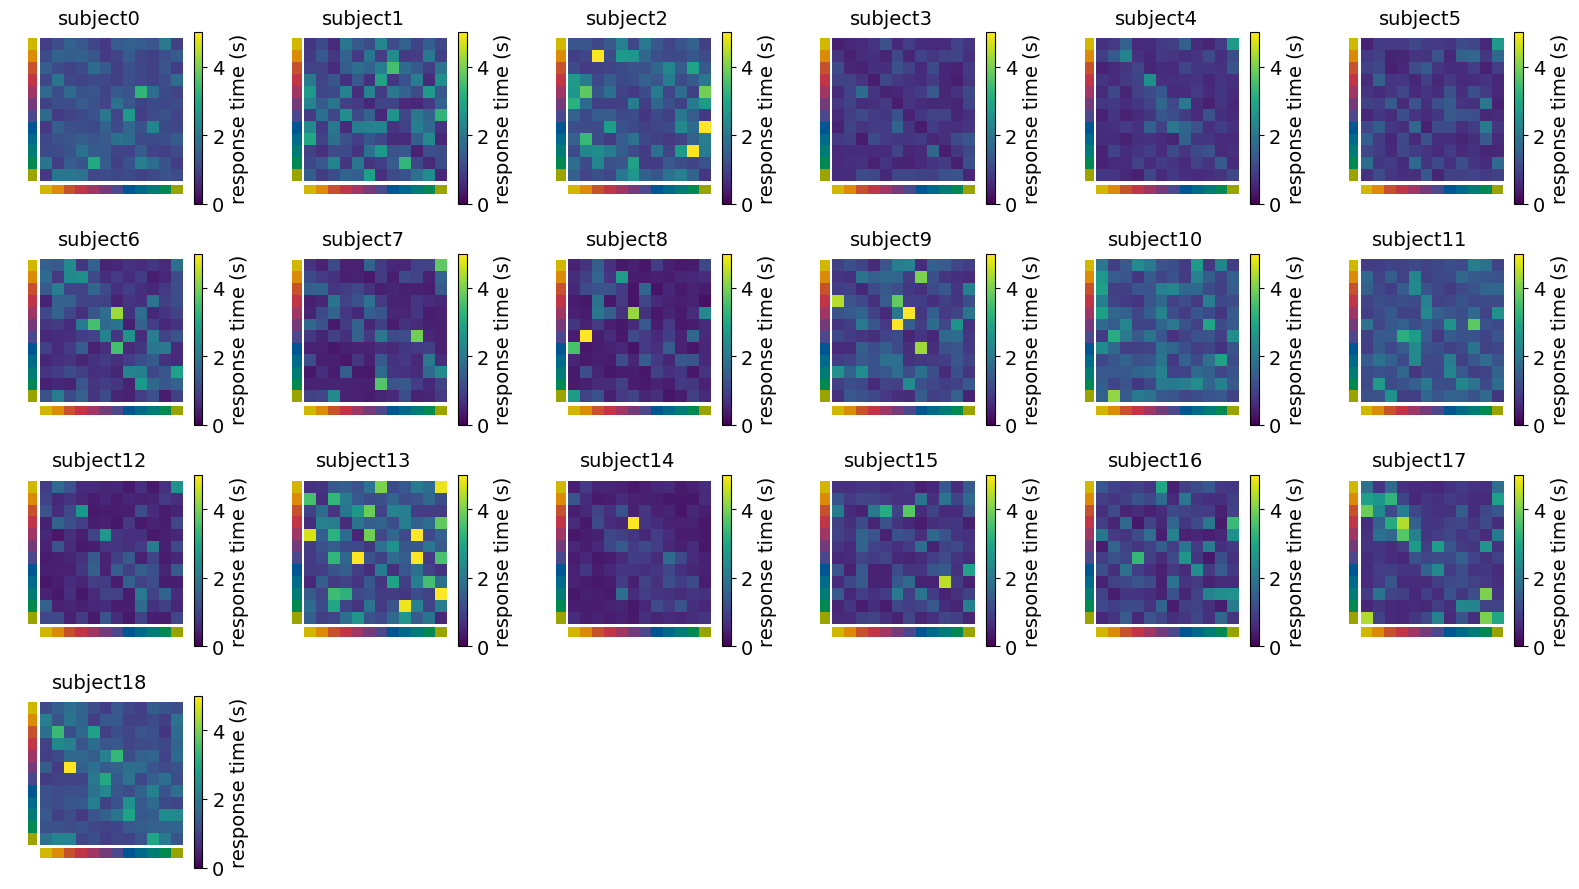

subject0 55132578fdf99b1b0568bdb8_kana_colourPreferenceQualia_2024-11-13_20h51.52.595.csv
subject1 5a9b20c535237b0001129820_kana_colourPreferenceQualia_2024-11-14_03h40.27.980.csv
subject2 5eb05d66438b180fe44f6929_kana_colourPreferenceQualia_2024-11-13_22h37.20.028.csv
subject3 609c1037e6c696620986cc20_kana_colourPreferenceQualia_2024-11-14_03h36.42.529.csv
subject4 60d1294f69a16ae3ac6301cd_kana_colourPreferenceQualia_2024-11-14_03h37.04.473.csv
subject5 61081452f93d7b4b161aa259_kana_colourPreferenceQualia_2024-11-13_20h46.56.032.csv
subject6 6171f34f6c376e1c7dd8dad0_kana_colourPreferenceQualia_2024-11-13_19h37.40.788.csv
subject7 65a3ab6491a3f0e753748680_kana_colourPreferenceQualia_2024-11-14_14h38.27.257.csv
subject8 65f13c4cbe73a841010ffca1_kana_colourPreferenceQualia_2024-11-14_08h37.56.050.csv
subject9 65f18d7e69e3e32de7794cf1_kana_colourPreferenceQualia_2024-11-14_07h08.16.789.csv
subject10 65fa3b371c3fff8d33be85bf_kana_colourPreferenceQualia_2024-11-14_07h38.27.714.csv
subject11

In [13]:
# Get data
pMatrices, pIds, pFiles = getDataColourMatrix(data_dir, data_column, response_type)

if data_column == 'responseTime':
    cLabel = 'response time (s)'
else:
    cLabel = response_type

# Show matrices
if data_column == 'response':
    # Range of raw response values
    colour_min = 0
    colour_max = 7
elif data_column == 'responseTime':
    # Range of response time values (0 is min)
    colour_min = 0
    colour_max = 5

utilityFunctions.show_heatmaps(colour_min, colour_max, pMatrices, 4, 6, titles=["subject" + str(p) for p in pIds], cbar_label= cLabel, color_labels=unique_colours)

for f in range(0, len(pFiles)):
    print("subject" + str(f) + ' ' + pFiles[f])


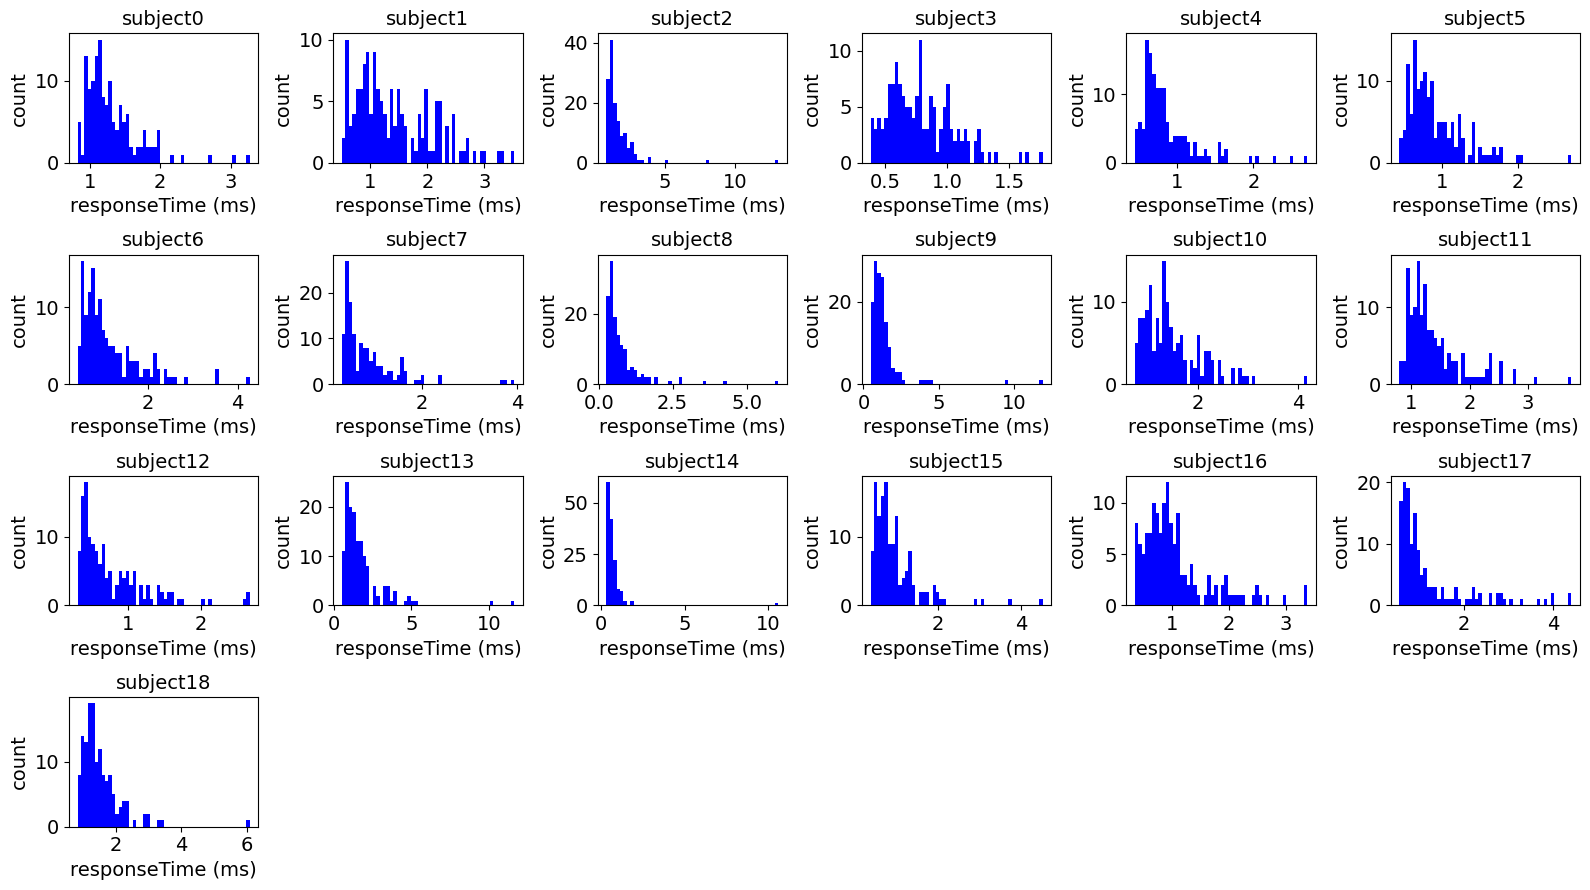

In [14]:
# Distribution of responses per participant

num_plots = len(pMatrices)
grid_size = math.ceil(math.sqrt(num_plots))  # Determine the grid size
fig, axs = plt.subplots(4, 6, figsize=(16, 9))#, figsize=(5 * grid_size, 5 * grid_size))
text_fontsize = 14

# Flatten the axes array if it is 2D
if isinstance(axs, np.ndarray):
    axs = axs.ravel()
else:
    axs = [axs]

if data_column == 'responseTime':
    xlabel = 'responseTime (ms)'
else:
    xlabel = data_column

for p in range(0, len(pMatrices)):
    ax = axs[p]

    ax.hist(pMatrices[p].flatten(), bins=50, color='blue')
    ax.set_xlabel(xlabel, fontsize=text_fontsize)
    ax.set_ylabel('count', fontsize=text_fontsize)
    ax.set_title('subject' + str(p), fontsize=text_fontsize)

    ax.tick_params(axis='both', labelsize=text_fontsize)

# Hide unused axes
for ax in axs[num_plots:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
tmp = pMatrices[0].flatten()

print(tmp)


Overall Pearson Correlation for 55132578fdf99b1b0568bdb8_kana_colourPreferenceQualia_2024-11-13_20h51.52.595.csv: 0.7717878941550479
Overall Pearson Correlation for 5a9b20c535237b0001129820_kana_colourPreferenceQualia_2024-11-14_03h40.27.980.csv: 0.6099395990903521
Overall Pearson Correlation for 5eb05d66438b180fe44f6929_kana_colourPreferenceQualia_2024-11-13_22h37.20.028.csv: 0.7250872236872207
Overall Pearson Correlation for 609c1037e6c696620986cc20_kana_colourPreferenceQualia_2024-11-14_03h36.42.529.csv: 0.8402225631078358
Overall Pearson Correlation for 60d1294f69a16ae3ac6301cd_kana_colourPreferenceQualia_2024-11-14_03h37.04.473.csv: 0.9402983133076946
Overall Pearson Correlation for 61081452f93d7b4b161aa259_kana_colourPreferenceQualia_2024-11-13_20h46.56.032.csv: 0.7193852323181652
Overall Pearson Correlation for 6171f34f6c376e1c7dd8dad0_kana_colourPreferenceQualia_2024-11-13_19h37.40.788.csv: 0.9211469440762557
Overall Pearson Correlation for 65a3ab6491a3f0e753748680_kana_colourP

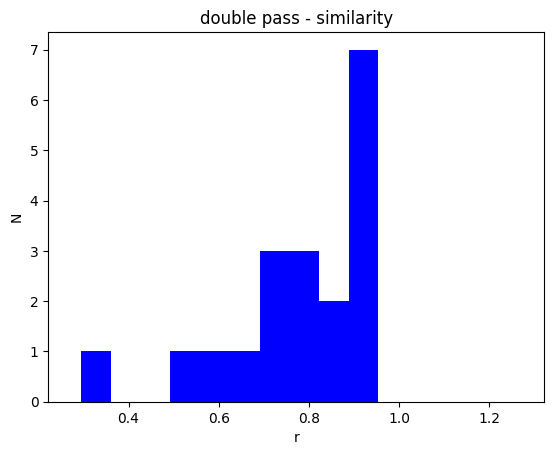

In [8]:
pCorrs = []

folder_path = 'raw_data/kana_colourpreferencequalia-master/data'

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        filepath = os.path.join(folder_path, filename)
        
        df = pd.read_csv(filepath, usecols=['response_type', 'response', 'colour1', 'colour2', 'trials.thisIndex', 'practice_trial'])

        # Omit practice trials
        df = df[df['practice_trial'] != 1] 

        df_similarity = df[df['response_type'] == 'similarity']

        # Group by 'trials.thisIndex'
        grouped = df_similarity.groupby('trials.thisIndex')['response'].apply(list).reset_index()

        # Filter for pairs with exactly two trials
        repeated_pairs = grouped[grouped['response'].apply(len) == 2]

        # Check if there are any repeated pairs
        if len(repeated_pairs) > 0:
            # Flatten the responses for repeated pairs
            responses_trial1 = np.array(repeated_pairs['response'].apply(lambda x: x[0]).tolist())
            responses_trial2 = np.array(repeated_pairs['response'].apply(lambda x: x[1]).tolist())

            # Calculate overall correlation for repeated color pairs
            overall_correlation = pearsonr(responses_trial1, responses_trial2)[0]

            pCorrs.append(overall_correlation)

            print(f"Overall Pearson Correlation for {filename}: {overall_correlation}")
        else:
            print(f"No repeated pairs found in {filename}")
    
    plt.hist(pCorrs, color='blue')
    plt.xlabel("r")
    plt.ylabel("N")
    plt.title('double pass - similarity')